# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.37KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

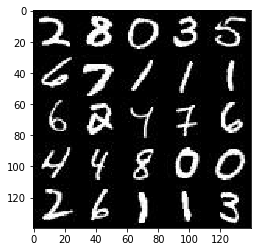

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [4]:
mnist_images.shape

(25, 28, 28, 1)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

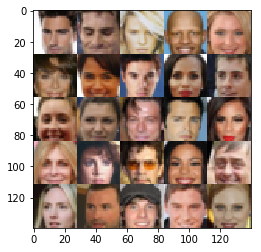

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeb_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

In [6]:
celeb_images.shape

(25, 28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [3]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [4]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer 28 x 28 x channels
        
        conv1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        # conv1 layer 14 x 14 x 64

        conv2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # conv2 layer 7 x 7 x 128

        conv3 = tf.layers.conv2d(relu1, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # conv2 layer 4 x 4 x 256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*256)
        
        x1 = tf.reshape(x1, (-1, 3, 3, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
#         x1 = tf.nn.dropout(x1, 0.5)
        # 3 x 3 x 256

        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=1)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         x2 = tf.nn.dropout(x2, 0.5)
        # 7 x 7 x 128

        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
#         x3 = tf.nn.dropout(x3, 0.5)
        # 14 x 14 x 64

        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        # 28 x 28 x channel_dim
        
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    d_real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_real_labels))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_fake_labels = tf.ones_like(d_model_fake) * (1 - smooth)
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_fake_labels))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_channels = 3 if data_image_mode == 'RGB' else 1
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
                    
        show_generator_output(sess, 20, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.8373
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.9143
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.3476
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 0.8686
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 1.4713
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 0.9638
Epoch 1/2... Discriminator Loss: 0.6487... Generator Loss: 1.6352
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 0.9101


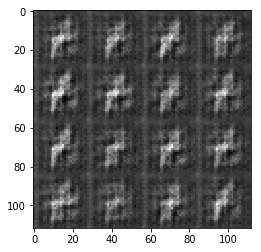

Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 0.7519
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.5921
Epoch 1/2... Discriminator Loss: 0.7160... Generator Loss: 1.6089
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 1.5044
Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 1.7749
Epoch 1/2... Discriminator Loss: 0.6567... Generator Loss: 1.7617
Epoch 1/2... Discriminator Loss: 0.8108... Generator Loss: 1.6153
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.0009


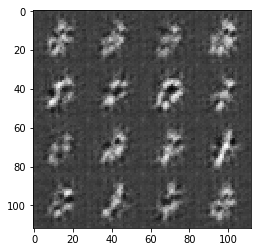

Epoch 1/2... Discriminator Loss: 0.8122... Generator Loss: 1.2946
Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 1.3191
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 1.8001
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 1.2227
Epoch 1/2... Discriminator Loss: 0.8182... Generator Loss: 1.3040
Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 1.4914
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 1.9010
Epoch 1/2... Discriminator Loss: 0.7309... Generator Loss: 1.5175
Epoch 1/2... Discriminator Loss: 0.8532... Generator Loss: 1.6332
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.4392


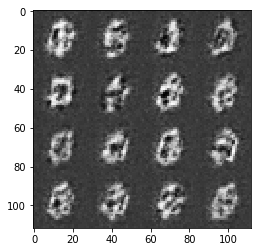

Epoch 1/2... Discriminator Loss: 0.7561... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 0.7304... Generator Loss: 1.6973
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 1.6460
Epoch 1/2... Discriminator Loss: 0.7215... Generator Loss: 1.5380
Epoch 1/2... Discriminator Loss: 0.6858... Generator Loss: 1.6188
Epoch 1/2... Discriminator Loss: 0.6672... Generator Loss: 1.5123
Epoch 1/2... Discriminator Loss: 0.6812... Generator Loss: 1.4583
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 1.4154
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.6353


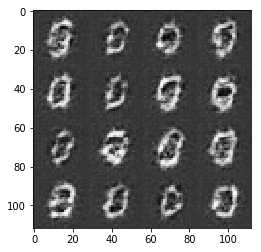

Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 1.7216
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 1.6322
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 1.9557
Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 1.9771
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 1.6160
Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 1.6088
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 1.6658
Epoch 1/2... Discriminator Loss: 0.6353... Generator Loss: 1.7544
Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 1.7996
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.5065


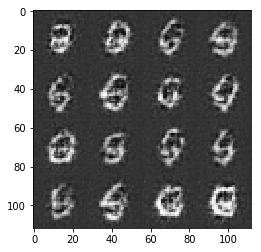

Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 1.9699
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 1.7197
Epoch 1/2... Discriminator Loss: 0.6109... Generator Loss: 1.6658
Epoch 1/2... Discriminator Loss: 0.6031... Generator Loss: 1.6859
Epoch 1/2... Discriminator Loss: 0.5922... Generator Loss: 1.7844
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.9335
Epoch 1/2... Discriminator Loss: 0.6433... Generator Loss: 1.7441
Epoch 1/2... Discriminator Loss: 0.6520... Generator Loss: 1.9517
Epoch 1/2... Discriminator Loss: 0.7627... Generator Loss: 1.7611


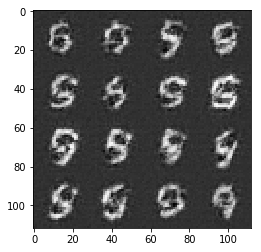

Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 1.2438
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 1.2359
Epoch 1/2... Discriminator Loss: 0.7274... Generator Loss: 1.5408
Epoch 1/2... Discriminator Loss: 0.6460... Generator Loss: 1.6323
Epoch 1/2... Discriminator Loss: 0.5683... Generator Loss: 1.8851
Epoch 1/2... Discriminator Loss: 0.6415... Generator Loss: 1.5242
Epoch 1/2... Discriminator Loss: 0.6165... Generator Loss: 1.7381
Epoch 1/2... Discriminator Loss: 0.6312... Generator Loss: 1.9278
Epoch 1/2... Discriminator Loss: 0.6073... Generator Loss: 1.8392
Epoch 1/2... Discriminator Loss: 0.5621... Generator Loss: 1.8489


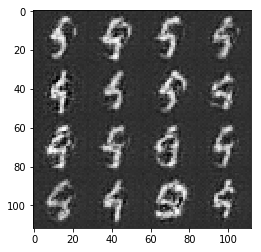

Epoch 1/2... Discriminator Loss: 0.5621... Generator Loss: 1.7840
Epoch 1/2... Discriminator Loss: 0.5874... Generator Loss: 2.0014
Epoch 1/2... Discriminator Loss: 0.5099... Generator Loss: 2.0384
Epoch 1/2... Discriminator Loss: 0.4959... Generator Loss: 2.1825
Epoch 1/2... Discriminator Loss: 0.6646... Generator Loss: 2.0718
Epoch 1/2... Discriminator Loss: 0.9779... Generator Loss: 2.1037
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 2.0368
Epoch 1/2... Discriminator Loss: 0.7318... Generator Loss: 1.7886
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.8728
Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 1.8292


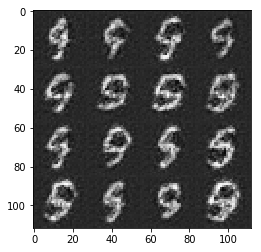

Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 1.8383
Epoch 1/2... Discriminator Loss: 0.5381... Generator Loss: 1.9783
Epoch 1/2... Discriminator Loss: 0.5425... Generator Loss: 1.9908
Epoch 1/2... Discriminator Loss: 0.6036... Generator Loss: 1.6634
Epoch 1/2... Discriminator Loss: 0.5286... Generator Loss: 2.1997
Epoch 1/2... Discriminator Loss: 0.5412... Generator Loss: 2.0638
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 2.1207
Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 2.0418
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 2.4470
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 1.9954


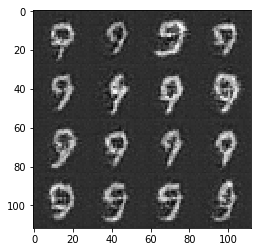

Epoch 1/2... Discriminator Loss: 0.5463... Generator Loss: 1.7881
Epoch 1/2... Discriminator Loss: 0.6675... Generator Loss: 2.1234
Epoch 1/2... Discriminator Loss: 0.6026... Generator Loss: 1.7994
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 1.7130
Epoch 1/2... Discriminator Loss: 0.5625... Generator Loss: 1.8658
Epoch 1/2... Discriminator Loss: 0.6880... Generator Loss: 1.7614
Epoch 1/2... Discriminator Loss: 0.5303... Generator Loss: 2.0190
Epoch 1/2... Discriminator Loss: 0.5927... Generator Loss: 1.9017
Epoch 1/2... Discriminator Loss: 0.5419... Generator Loss: 2.1287
Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 1.7989


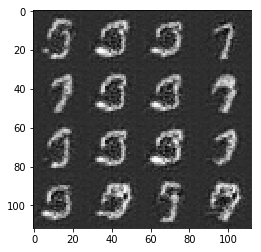

Epoch 1/2... Discriminator Loss: 0.8462... Generator Loss: 2.0065
Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 2.0513
Epoch 1/2... Discriminator Loss: 0.5755... Generator Loss: 2.0229
Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 2.2080
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 1.7871
Epoch 1/2... Discriminator Loss: 0.5318... Generator Loss: 1.9420
Epoch 1/2... Discriminator Loss: 0.6484... Generator Loss: 1.7140
Epoch 1/2... Discriminator Loss: 0.5016... Generator Loss: 2.1487
Epoch 1/2... Discriminator Loss: 0.5834... Generator Loss: 2.0192
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 1.8245


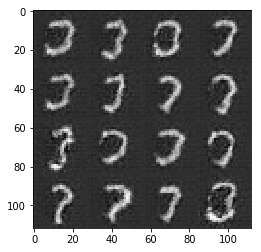

Epoch 1/2... Discriminator Loss: 0.5869... Generator Loss: 1.9538
Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 1.9614
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 2.5476
Epoch 1/2... Discriminator Loss: 1.5138... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 0.6083... Generator Loss: 1.9195
Epoch 1/2... Discriminator Loss: 0.6687... Generator Loss: 1.7420
Epoch 1/2... Discriminator Loss: 0.5821... Generator Loss: 1.7095
Epoch 1/2... Discriminator Loss: 0.6168... Generator Loss: 2.0412
Epoch 1/2... Discriminator Loss: 0.5390... Generator Loss: 2.2352
Epoch 1/2... Discriminator Loss: 0.6106... Generator Loss: 1.7976


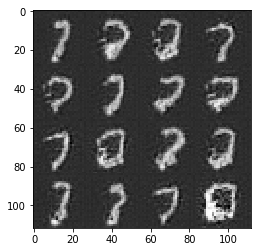

Epoch 1/2... Discriminator Loss: 0.6964... Generator Loss: 2.1652
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 1.9667
Epoch 1/2... Discriminator Loss: 0.6011... Generator Loss: 2.1712
Epoch 1/2... Discriminator Loss: 0.5817... Generator Loss: 1.9484
Epoch 1/2... Discriminator Loss: 0.5644... Generator Loss: 1.7238
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 1.8596
Epoch 1/2... Discriminator Loss: 0.5477... Generator Loss: 1.8694
Epoch 1/2... Discriminator Loss: 0.5117... Generator Loss: 2.0471
Epoch 1/2... Discriminator Loss: 0.6876... Generator Loss: 2.3579
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.9527


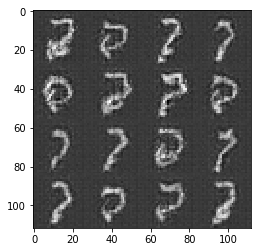

Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 1.7063
Epoch 1/2... Discriminator Loss: 0.6037... Generator Loss: 1.9470
Epoch 1/2... Discriminator Loss: 0.6485... Generator Loss: 1.9671
Epoch 1/2... Discriminator Loss: 0.6938... Generator Loss: 1.8425
Epoch 1/2... Discriminator Loss: 0.5413... Generator Loss: 1.9595
Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 1.9497
Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.8378
Epoch 1/2... Discriminator Loss: 0.5308... Generator Loss: 2.1150
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 2.0187
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 1.9752


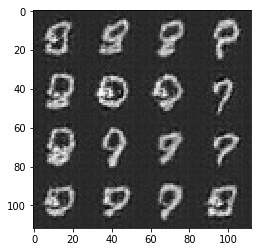

Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 1.9596
Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 2.2834
Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 1.7722
Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 1.6997
Epoch 1/2... Discriminator Loss: 0.6051... Generator Loss: 1.8237
Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 1.9484
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 1.8695
Epoch 1/2... Discriminator Loss: 0.6010... Generator Loss: 1.8993
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 2.2032


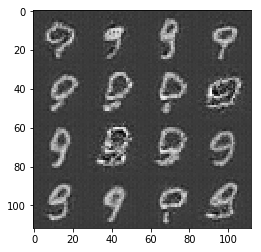

Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 2.0140
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 2.0231
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 1.5891
Epoch 1/2... Discriminator Loss: 0.6223... Generator Loss: 1.8724
Epoch 1/2... Discriminator Loss: 0.5737... Generator Loss: 1.8390
Epoch 1/2... Discriminator Loss: 0.5386... Generator Loss: 1.9677
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 2.1561
Epoch 1/2... Discriminator Loss: 0.6392... Generator Loss: 2.1835
Epoch 1/2... Discriminator Loss: 0.5880... Generator Loss: 2.2148
Epoch 1/2... Discriminator Loss: 0.5302... Generator Loss: 2.0552


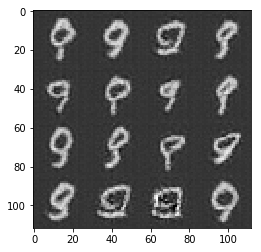

Epoch 1/2... Discriminator Loss: 0.5199... Generator Loss: 2.2764
Epoch 1/2... Discriminator Loss: 0.6268... Generator Loss: 1.9844
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 2.3835
Epoch 1/2... Discriminator Loss: 3.3330... Generator Loss: 4.5685
Epoch 1/2... Discriminator Loss: 0.6964... Generator Loss: 1.9395
Epoch 1/2... Discriminator Loss: 0.8727... Generator Loss: 1.7338
Epoch 1/2... Discriminator Loss: 0.6293... Generator Loss: 1.7700
Epoch 1/2... Discriminator Loss: 0.6071... Generator Loss: 1.7564
Epoch 1/2... Discriminator Loss: 0.6593... Generator Loss: 1.7232
Epoch 1/2... Discriminator Loss: 0.6378... Generator Loss: 1.7963


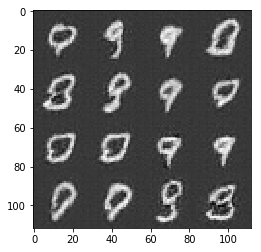

Epoch 1/2... Discriminator Loss: 0.6085... Generator Loss: 1.9341
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.5053
Epoch 1/2... Discriminator Loss: 0.6860... Generator Loss: 1.9610
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 1.9504
Epoch 1/2... Discriminator Loss: 0.5730... Generator Loss: 1.8046
Epoch 1/2... Discriminator Loss: 0.5659... Generator Loss: 1.8139
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 1.8081
Epoch 1/2... Discriminator Loss: 0.7330... Generator Loss: 1.3747
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.8511
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 1.8190


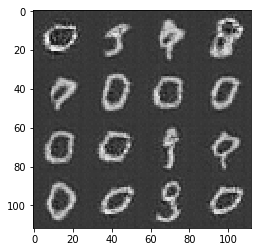

Epoch 1/2... Discriminator Loss: 0.5554... Generator Loss: 1.9662
Epoch 1/2... Discriminator Loss: 0.5648... Generator Loss: 1.8160
Epoch 1/2... Discriminator Loss: 0.5996... Generator Loss: 1.8496
Epoch 1/2... Discriminator Loss: 0.7082... Generator Loss: 1.6481
Epoch 1/2... Discriminator Loss: 0.5651... Generator Loss: 2.0361
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 1.7672
Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 1.8117
Epoch 2/2... Discriminator Loss: 0.6305... Generator Loss: 2.2529
Epoch 2/2... Discriminator Loss: 0.6084... Generator Loss: 1.7372
Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 1.9035


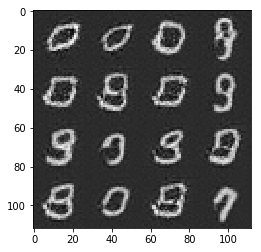

Epoch 2/2... Discriminator Loss: 0.6664... Generator Loss: 1.8596
Epoch 2/2... Discriminator Loss: 0.7068... Generator Loss: 2.1636
Epoch 2/2... Discriminator Loss: 0.5985... Generator Loss: 2.2798
Epoch 2/2... Discriminator Loss: 1.5966... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 1.3987
Epoch 2/2... Discriminator Loss: 0.6786... Generator Loss: 1.5360
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.6404
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.8487
Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 1.7381
Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 1.7826


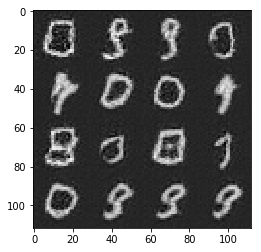

Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.8678
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 1.8547
Epoch 2/2... Discriminator Loss: 0.6590... Generator Loss: 1.5517
Epoch 2/2... Discriminator Loss: 0.5655... Generator Loss: 1.8811
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.4995
Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 1.5745
Epoch 2/2... Discriminator Loss: 0.6394... Generator Loss: 1.6487
Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 1.7880
Epoch 2/2... Discriminator Loss: 0.6167... Generator Loss: 1.8565
Epoch 2/2... Discriminator Loss: 0.5723... Generator Loss: 1.9174


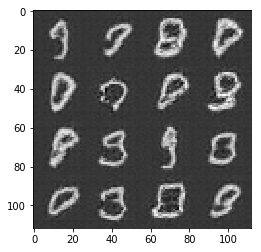

Epoch 2/2... Discriminator Loss: 0.5615... Generator Loss: 2.1650
Epoch 2/2... Discriminator Loss: 0.5402... Generator Loss: 1.9857
Epoch 2/2... Discriminator Loss: 0.6308... Generator Loss: 1.8122
Epoch 2/2... Discriminator Loss: 0.5552... Generator Loss: 2.1689
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 2.3521
Epoch 2/2... Discriminator Loss: 0.6848... Generator Loss: 1.8155
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.5954
Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 2.4797
Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 2.0654
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 2.1235


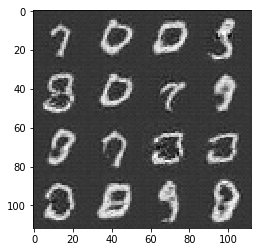

Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 1.6326
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 1.8087
Epoch 2/2... Discriminator Loss: 0.6200... Generator Loss: 1.9421
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 2.1383
Epoch 2/2... Discriminator Loss: 0.5757... Generator Loss: 1.7819
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.9425
Epoch 2/2... Discriminator Loss: 0.6045... Generator Loss: 2.1257
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.9866
Epoch 2/2... Discriminator Loss: 0.5887... Generator Loss: 2.1742
Epoch 2/2... Discriminator Loss: 0.5319... Generator Loss: 2.2006


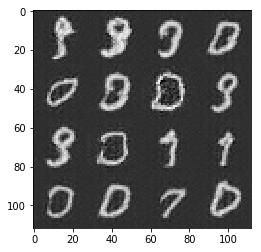

Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.9804
Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 2.1278
Epoch 2/2... Discriminator Loss: 0.6364... Generator Loss: 1.9996
Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 1.8663
Epoch 2/2... Discriminator Loss: 0.6340... Generator Loss: 2.0110
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.4368
Epoch 2/2... Discriminator Loss: 0.5389... Generator Loss: 2.0889
Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 1.8689
Epoch 2/2... Discriminator Loss: 0.5286... Generator Loss: 2.1663
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.7961


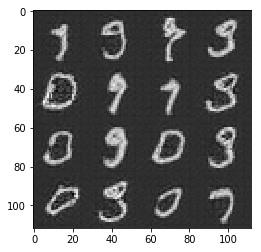

Epoch 2/2... Discriminator Loss: 0.4996... Generator Loss: 2.3789
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 2.1261
Epoch 2/2... Discriminator Loss: 0.6089... Generator Loss: 1.8906
Epoch 2/2... Discriminator Loss: 0.6218... Generator Loss: 2.1497
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.5979
Epoch 2/2... Discriminator Loss: 0.5835... Generator Loss: 2.2300
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.8137
Epoch 2/2... Discriminator Loss: 0.5187... Generator Loss: 2.2210
Epoch 2/2... Discriminator Loss: 0.7104... Generator Loss: 2.0928
Epoch 2/2... Discriminator Loss: 0.6789... Generator Loss: 2.2245


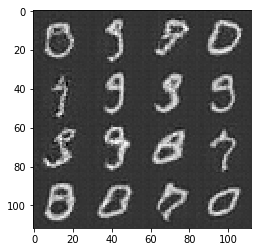

Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 3.1961
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.6353
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 1.9049
Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 1.8040
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.9991
Epoch 2/2... Discriminator Loss: 0.7597... Generator Loss: 1.9417
Epoch 2/2... Discriminator Loss: 0.6368... Generator Loss: 2.2199
Epoch 2/2... Discriminator Loss: 0.5770... Generator Loss: 1.9654
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 1.8675
Epoch 2/2... Discriminator Loss: 0.5764... Generator Loss: 1.9187


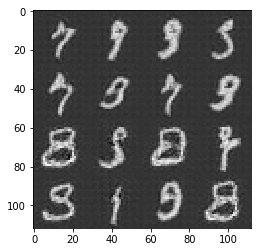

Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 2.1687
Epoch 2/2... Discriminator Loss: 0.8292... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 1.5361
Epoch 2/2... Discriminator Loss: 0.7881... Generator Loss: 1.5267
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 1.7690
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.6410
Epoch 2/2... Discriminator Loss: 0.6060... Generator Loss: 1.7895
Epoch 2/2... Discriminator Loss: 0.6588... Generator Loss: 2.0379
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.8579
Epoch 2/2... Discriminator Loss: 0.5635... Generator Loss: 1.9808


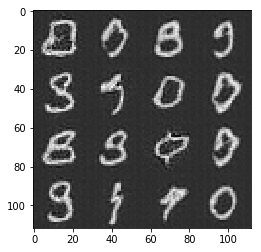

Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 2.2829
Epoch 2/2... Discriminator Loss: 0.5526... Generator Loss: 2.0353
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.8619
Epoch 2/2... Discriminator Loss: 0.6748... Generator Loss: 1.7723
Epoch 2/2... Discriminator Loss: 0.5676... Generator Loss: 2.2032
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 1.8636
Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 1.7096
Epoch 2/2... Discriminator Loss: 0.5655... Generator Loss: 2.1099
Epoch 2/2... Discriminator Loss: 0.5349... Generator Loss: 1.9472
Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 1.8487


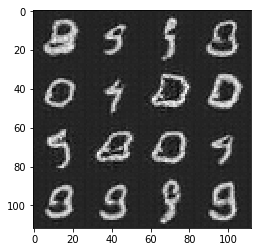

Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 1.9793
Epoch 2/2... Discriminator Loss: 0.7112... Generator Loss: 1.9279
Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 1.4740
Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 1.5614
Epoch 2/2... Discriminator Loss: 0.5615... Generator Loss: 1.9873
Epoch 2/2... Discriminator Loss: 0.7394... Generator Loss: 1.7179
Epoch 2/2... Discriminator Loss: 0.6062... Generator Loss: 1.8325
Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 2.1560
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 1.9734
Epoch 2/2... Discriminator Loss: 0.6127... Generator Loss: 1.8626


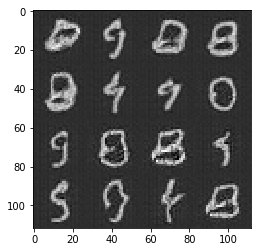

Epoch 2/2... Discriminator Loss: 0.6667... Generator Loss: 2.0175
Epoch 2/2... Discriminator Loss: 0.5987... Generator Loss: 1.8011
Epoch 2/2... Discriminator Loss: 0.5356... Generator Loss: 1.9988
Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 2.0179
Epoch 2/2... Discriminator Loss: 0.5896... Generator Loss: 2.0089
Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 1.5394
Epoch 2/2... Discriminator Loss: 0.6514... Generator Loss: 1.9373
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.4106
Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 1.7066
Epoch 2/2... Discriminator Loss: 0.6397... Generator Loss: 2.0158


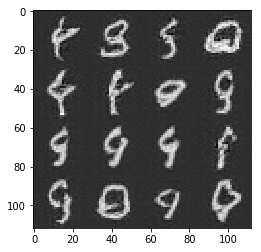

Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 1.8875
Epoch 2/2... Discriminator Loss: 0.5216... Generator Loss: 2.2890
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.7472
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 1.9292
Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 2.0998
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.9779
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 2.1053
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 1.7699
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 1.6450
Epoch 2/2... Discriminator Loss: 0.5998... Generator Loss: 1.7847


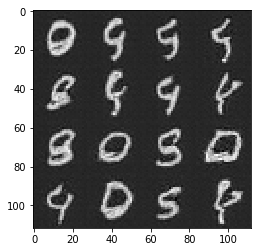

Epoch 2/2... Discriminator Loss: 0.5539... Generator Loss: 2.0313
Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 1.8442
Epoch 2/2... Discriminator Loss: 0.8423... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.7661
Epoch 2/2... Discriminator Loss: 0.6159... Generator Loss: 1.8573
Epoch 2/2... Discriminator Loss: 0.6674... Generator Loss: 1.8266
Epoch 2/2... Discriminator Loss: 0.6594... Generator Loss: 2.0303
Epoch 2/2... Discriminator Loss: 0.6464... Generator Loss: 1.8992
Epoch 2/2... Discriminator Loss: 0.6465... Generator Loss: 1.9039
Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 2.0013


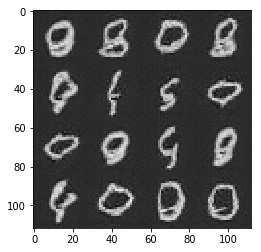

Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 1.9682
Epoch 2/2... Discriminator Loss: 0.6902... Generator Loss: 2.1811
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 2.3119
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 1.7861
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 2.0472
Epoch 2/2... Discriminator Loss: 0.6708... Generator Loss: 1.8420
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 2.0514
Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.9928
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.9425
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 2.1448


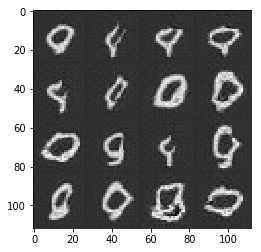

Epoch 2/2... Discriminator Loss: 0.6343... Generator Loss: 1.7222
Epoch 2/2... Discriminator Loss: 0.6625... Generator Loss: 1.8918
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 1.8610
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 1.8548
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 2.2794
Epoch 2/2... Discriminator Loss: 0.7062... Generator Loss: 2.0994
Epoch 2/2... Discriminator Loss: 0.5954... Generator Loss: 2.0037
Epoch 2/2... Discriminator Loss: 0.6362... Generator Loss: 1.6831
Epoch 2/2... Discriminator Loss: 0.5924... Generator Loss: 2.2281
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 2.2299


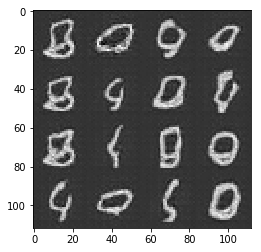

Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.9019
Epoch 2/2... Discriminator Loss: 0.6197... Generator Loss: 1.9880
Epoch 2/2... Discriminator Loss: 0.6160... Generator Loss: 1.7828
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.8960
Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 2.0093
Epoch 2/2... Discriminator Loss: 0.6363... Generator Loss: 2.0213
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 1.8134
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 2.0702
Epoch 2/2... Discriminator Loss: 0.5121... Generator Loss: 2.1577
Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 1.9799


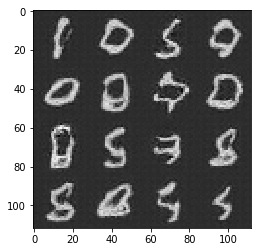

Epoch 2/2... Discriminator Loss: 0.6386... Generator Loss: 1.9962
Epoch 2/2... Discriminator Loss: 0.6645... Generator Loss: 2.1517
Epoch 2/2... Discriminator Loss: 0.8550... Generator Loss: 2.5388
Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 2.1659
Epoch 2/2... Discriminator Loss: 0.5998... Generator Loss: 1.7442
Epoch 2/2... Discriminator Loss: 0.6103... Generator Loss: 1.8285
Epoch 2/2... Discriminator Loss: 0.7134... Generator Loss: 2.2954
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 1.7034
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 1.6850
Epoch 2/2... Discriminator Loss: 0.7276... Generator Loss: 1.8816


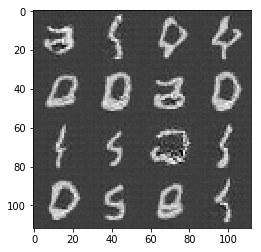

Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.5214
Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 1.9379
Epoch 2/2... Discriminator Loss: 0.6586... Generator Loss: 1.9262
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 1.7007
Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.9156
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 1.6786
Epoch 2/2... Discriminator Loss: 0.6067... Generator Loss: 1.9445
Epoch 2/2... Discriminator Loss: 0.6395... Generator Loss: 1.9715
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.5088
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 1.4453


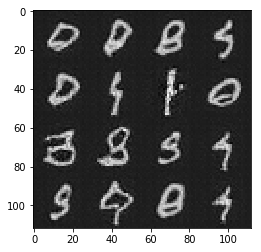

Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.6558
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 1.9698
Epoch 2/2... Discriminator Loss: 0.7240... Generator Loss: 1.6938
Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 1.4220
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 1.3653


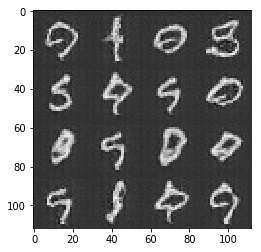

In [32]:
from glob import glob
from matplotlib import pyplot
import os

batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 2.3793
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 3.0212
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 2.8418
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 3.5910
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 2.8525
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 3.2358


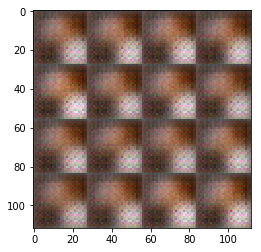

Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 1.5852
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 3.7749
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 4.3404
Epoch 1/1... Discriminator Loss: 0.4490... Generator Loss: 2.3048
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 2.0179
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.9753
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 3.4718
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 4.2107
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 3.8430
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.2652


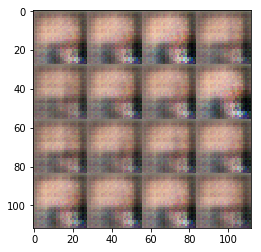

Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 3.1728
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.6758
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 1.6139
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 1.7500
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 1.7424
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 3.7046
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.5799
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 2.6625
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.1369


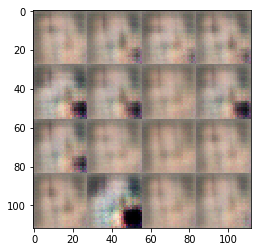

Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 1.8631
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 1.8826
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 3.1257
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 1.7562
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 2.6275
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 2.5922
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 1.8964
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 3.7300
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 2.8043
Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 1.6650


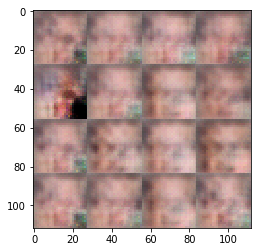

Epoch 1/1... Discriminator Loss: 3.7450... Generator Loss: 2.5213
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.2385
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.3805
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.5162
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.3816


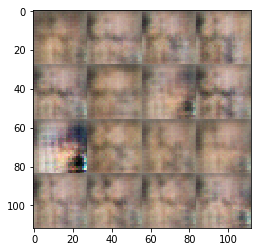

Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.2897
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 1.4321
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 1.8451
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.8608
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.7724
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 1.5400


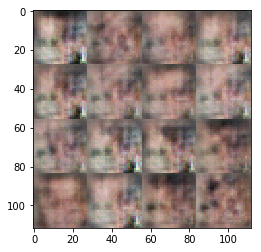

Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 3.8010
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.4773
Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.5991
Epoch 1/1... Discriminator Loss: 2.0263... Generator Loss: 3.5593
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 2.8709
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 2.4016
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.3443


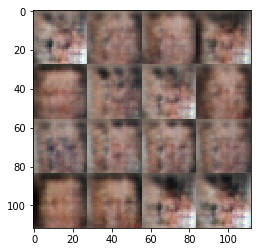

Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 2.2259
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 1.6883
Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 1.9151
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.9228
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 2.9594
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 2.0254
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.7328
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 2.4919


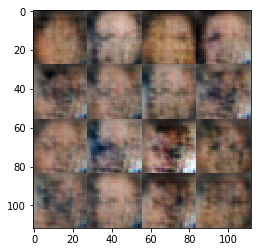

Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 3.1521
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 1.7217
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.6411
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 2.2056
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.9275
Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 1.9194
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 2.2218
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.6852
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 1.4231


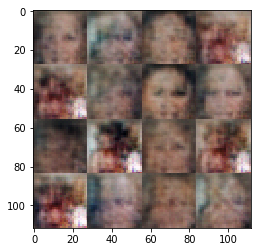

Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.7041
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 2.5017
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.6188
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.6499
Epoch 1/1... Discriminator Loss: 3.7858... Generator Loss: 1.5555
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.4813
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.1801


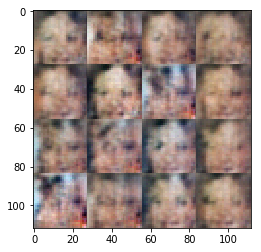

Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.3905
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 2.0733
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.2928


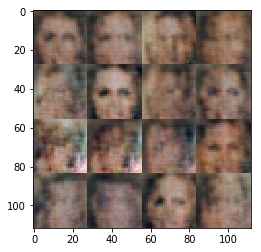

Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.2317
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 2.3146
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 2.2811
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.9565
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.8201
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.5384
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 2.5802
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.2581
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 2.0306


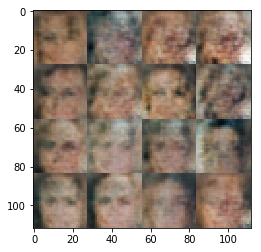

Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.5500
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 2.4057
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.7214
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.6368
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 2.2446
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.5316
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 2.0488
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 1.9148
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 5.5635


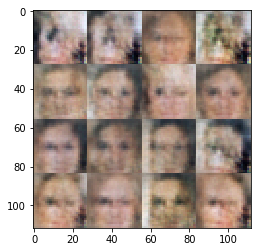

Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 1.4331
Epoch 1/1... Discriminator Loss: 1.7179... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 1.9965... Generator Loss: 1.5530
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.0939


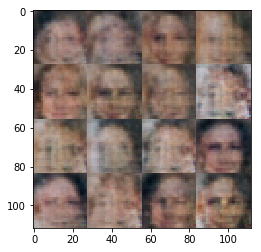

Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.3854
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 1.8152
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.3427
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.4640


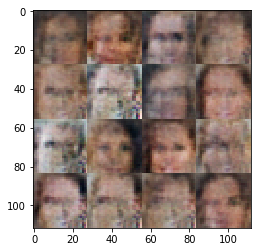

Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 2.0806
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.5310
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.0920
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.2813
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.5492
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.3419


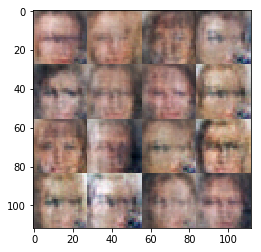

Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.3847
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.6299
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.1305


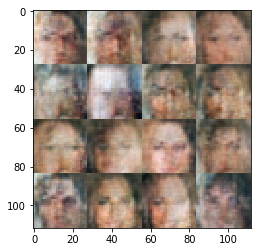

Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.6468
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.1679


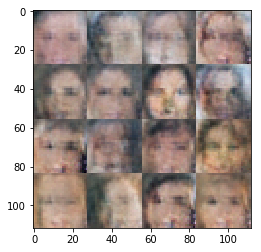

Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 2.0003
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.1879
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 4.3176... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.7138


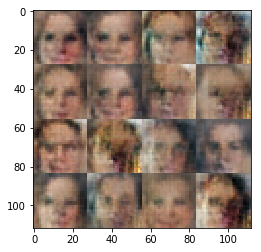

Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.3465
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.5599
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.0627


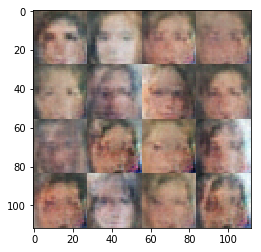

Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.3305
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.0598


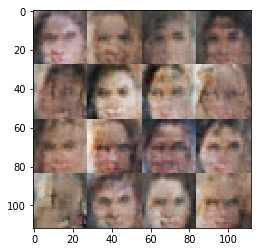

Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 8.4211... Generator Loss: 3.4354
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.9486


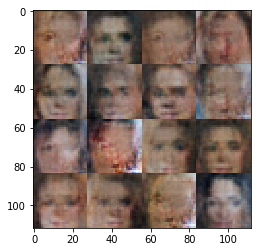

Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.4685
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.2313
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.1164


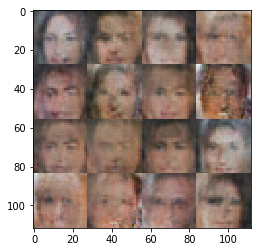

Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.9080


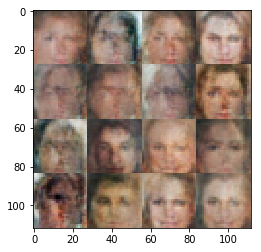

Epoch 1/1... Discriminator Loss: 1.6495... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.1677


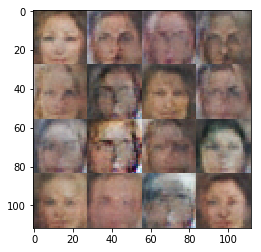

Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.2862
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.0730


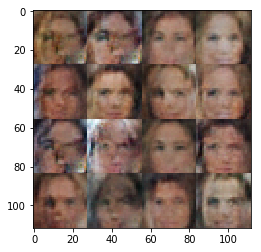

Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 1.6783... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.0320


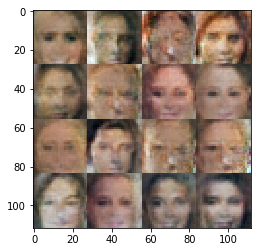

Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.1654


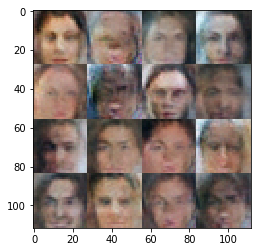

Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.3642
Epoch 1/1... Discriminator Loss: 3.7886... Generator Loss: 1.9453
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.2567
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.9724


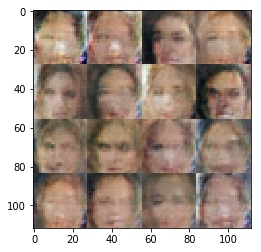

Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.0196
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.1753


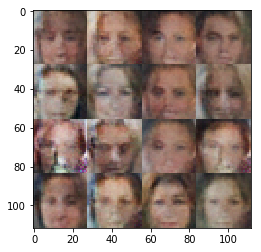

Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.1880
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0489


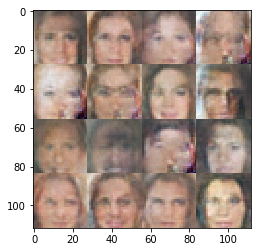

Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.5368


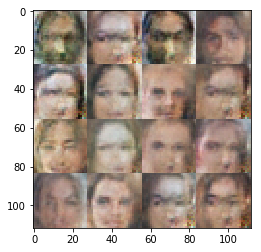

Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.4153
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.3539


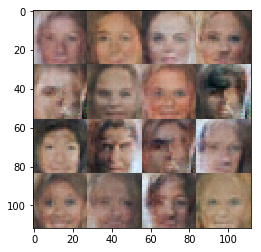

Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.2903
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.8197
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 3.9132... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.1140


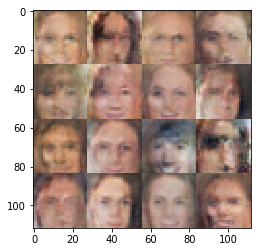

Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.8907


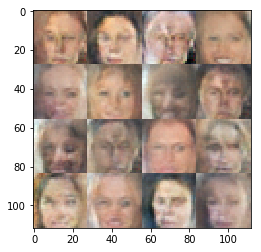

Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.2551
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.1385


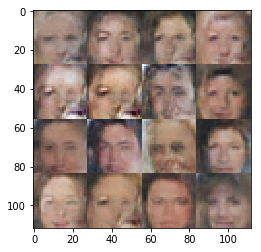

Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.3773
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.2963
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.1115


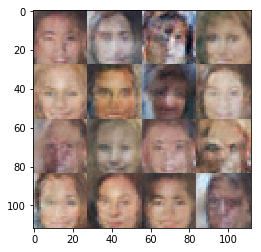

Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.5760
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.9060


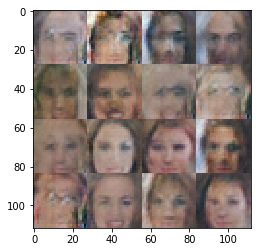

Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.2530


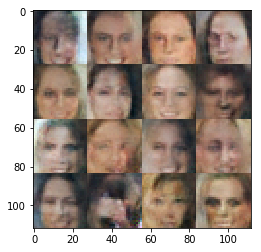

Epoch 1/1... Discriminator Loss: 14.3440... Generator Loss: 6.1559
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 2.0497... Generator Loss: 1.5055
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.9394


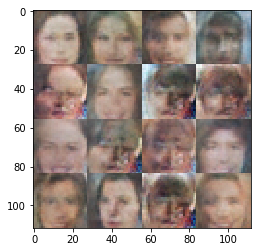

Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.9086


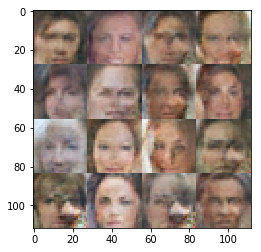

Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.1504
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.0190


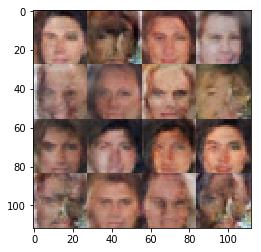

Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.2836


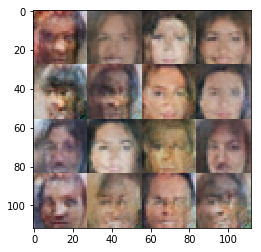

Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 3.8747... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 2.9160... Generator Loss: 1.4272
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.9314


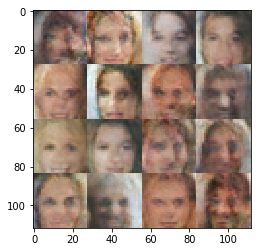

Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.9665


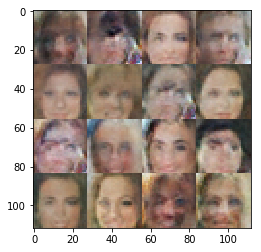

Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.9328


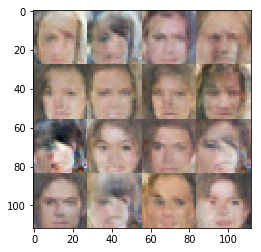

Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.5293


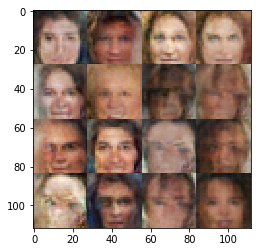

Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.9904


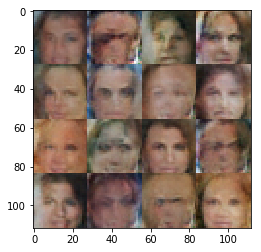

Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.0174


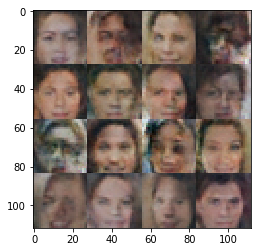

Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.7551... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 2.4568... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 1.1145


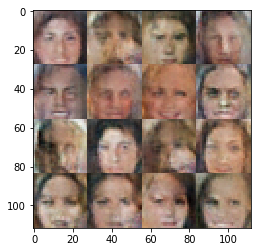

Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.9877


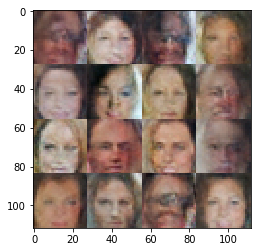

Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.0135


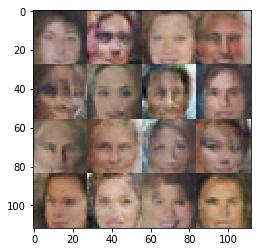

Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 2.0980... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.2078


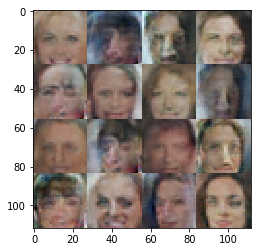

Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.0970


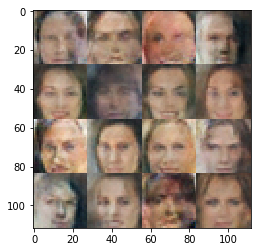

Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.9875


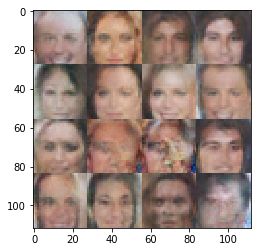

Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.4790
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.9914


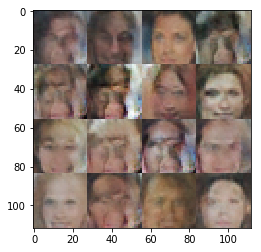

Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.2177
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.0364


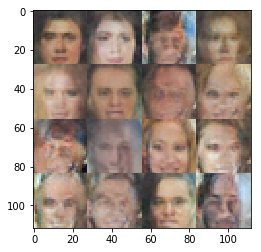

Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 1.0150


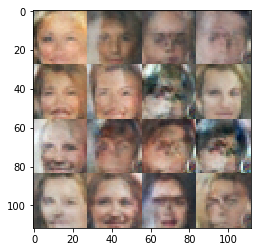

Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.2491
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.3918
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.9871


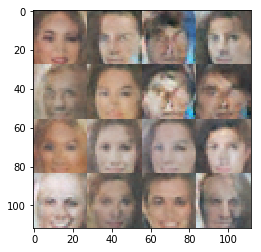

Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 2.1909... Generator Loss: 1.9857


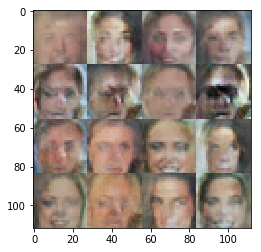

Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.9074


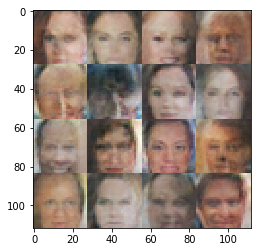

Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8883


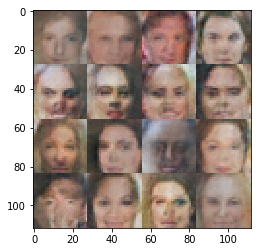

Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 1.6175
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.8204


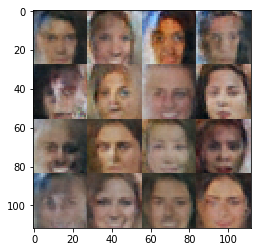

Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.3137


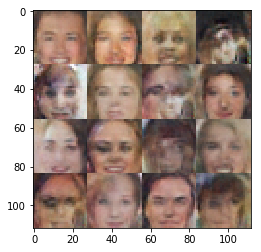

In [33]:
batch_size = 32
z_dim = 200
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.